## 📘 Introduction

In today's data-driven world, compensation analysis is essential for ensuring fairness, attracting top talent, and optimizing organizational resources. This project explores a synthetic **Employer Dataset**, which simulates real-world employee data, to develop a predictive model for estimating employee salaries based on various personal and professional attributes.

The goal of this notebook is to perform **end-to-end salary prediction** using structured employee data. We will walk through each critical step in the machine learning pipeline:

*  **Data Preprocessing**: Cleaning, encoding, and transforming categorical and numerical features
*  **Exploratory Data Analysis (EDA)**: Understanding feature distributions, patterns, and relationships with salary
*  **Model Building**: Training and evaluating multiple regression models including Linear Regression, Decision Trees, Random Forests, and more
*  **Performance Comparison**: Using metrics like MAE, RMSE, and R² Score to evaluate and compare model accuracy
*  **Interpretability**: Analyzing feature importance to understand the drivers of salary prediction

This notebook is designed to demonstrate practical machine learning workflows, model evaluation, and responsible feature handling in HR analytics. Since the dataset is synthetic, it provides a safe and controlled environment to experiment and develop robust ML models.

#### Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## EDA

In [2]:
df = pd.read_csv('/kaggle/input/employer-data/Employers_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Employee_ID       10000 non-null  int64 
 1   Name              10000 non-null  object
 2   Age               10000 non-null  int64 
 3   Gender            10000 non-null  object
 4   Department        10000 non-null  object
 5   Job_Title         10000 non-null  object
 6   Experience_Years  10000 non-null  int64 
 7   Education_Level   10000 non-null  object
 8   Location          10000 non-null  object
 9   Salary            10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [4]:
df.isna().sum()

Employee_ID         0
Name                0
Age                 0
Gender              0
Department          0
Job_Title           0
Experience_Years    0
Education_Level     0
Location            0
Salary              0
dtype: int64

In [5]:
df

,Employee_ID,Name,Age,Gender,Department,Job_Title,Experience_Years,Education_Level,Location,Salary
0,1,Merle Ingram,24,Female,Engineering,Engineer,1,Master,Austin,90000
1,2,John Mayes,56,Male,Sales,Executive,33,Master,Seattle,195000
2,3,Carlos Wille,21,Male,Engineering,Intern,1,Bachelor,New York,35000
3,4,Michael Bryant,30,Male,Finance,Analyst,9,Bachelor,New York,75000
4,5,Paula Douglas,25,Female,HR,Analyst,2,Master,Seattle,70000
...,...,...,...,...,...,...,...,...,...,...
9995,9996,Thomas Rossin,51,Male,Sales,Executive,28,Master,Austin,185000
9996,9997,Christie King,36,Female,Sales,Executive,9,PhD,San Francisco,165000
9997,9998,Alfred Keller,57,Male,Sales,Executive,30,PhD,New York,200000
9998,9999,Margaret Gomez,37,Female,Engineering,Manager,14,Master,New York,135000


In [6]:
df.describe()

,Employee_ID,Age,Experience_Years,Salary
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,35.455900,12.370900,115381.500000
std,2886.89568,10.000213,9.148951,46066.139047
min,1.00000,21.000000,0.000000,25000.000000
25%,2500.75000,27.000000,5.000000,70000.000000
50%,5000.50000,34.000000,10.000000,120000.000000
75%,7500.25000,43.000000,19.000000,150000.000000
max,10000.00000,60.000000,37.000000,215000.000000


Drop ID and Name

In [7]:
df = df.drop(columns=["Employee_ID", "Name"])

## EDA

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


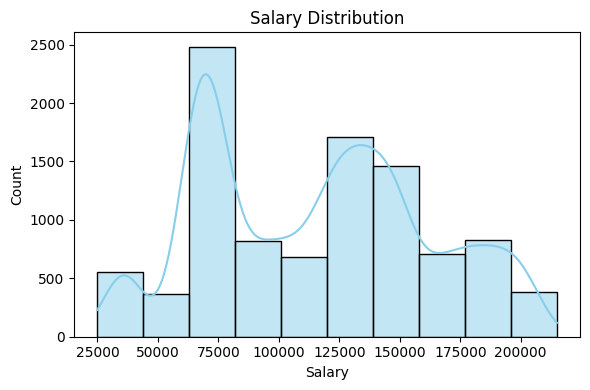

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(df["Salary"], kde=True, bins=10, color="skyblue")
plt.title("Salary Distribution")
plt.xlabel("Salary")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



The salary distribution is strongly right-skewed, peaking at 25K-50K (most employees) with sharp declines above 100K and no sub-25K earners, indicating typical corporate hierarchy and requiring log transformation for accurate modeling.**

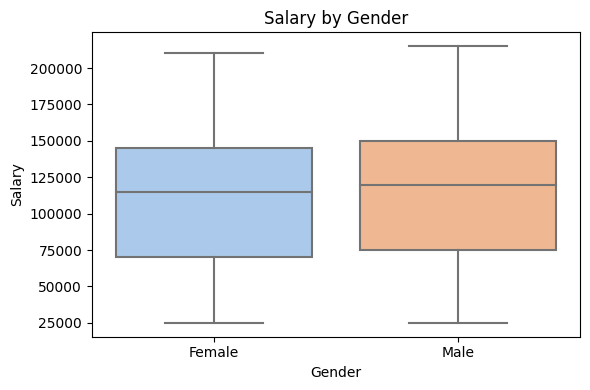

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Gender", y="Salary", data=df, palette="pastel")
plt.title("Salary by Gender")
plt.tight_layout()
plt.show()


Male median salary (100K) exceeds female (75K) with wider range and high-earning outliers (up to $200K)

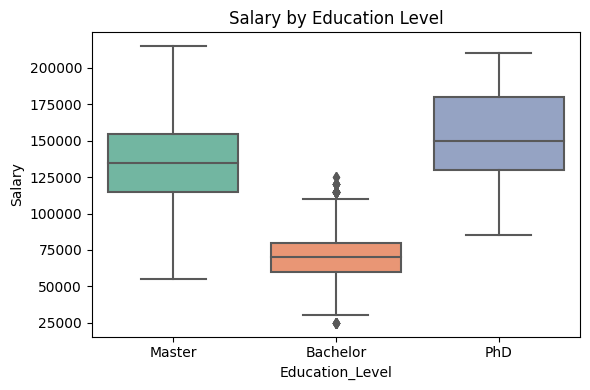

In [10]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Education_Level", y="Salary", data=df, palette="Set2")
plt.title("Salary by Education Level")
plt.tight_layout()
plt.show()

PhD holders command the highest median salary (150K), surpassing Master's (100K) and Bachelor's (75K), with doctoral salaries showing wider dispersion and reaching peak earnings of ~$200K, demonstrating a clear education premium.



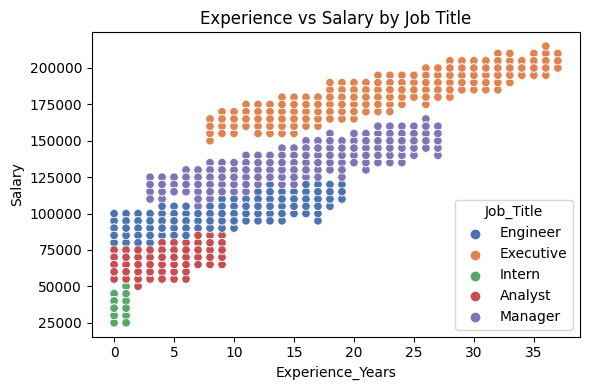

In [11]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x="Experience_Years", y="Salary", hue="Job_Title", data=df, palette="deep")
plt.title("Experience vs Salary by Job Title")
plt.tight_layout()
plt.show()

Executives show the strongest experience-salary correlation, reaching 200K at 25+ years, while Managers/Engineers exhibit moderate growth; Analysts plateau near 100K, and Interns remain low-earning with minimal experience dependency.



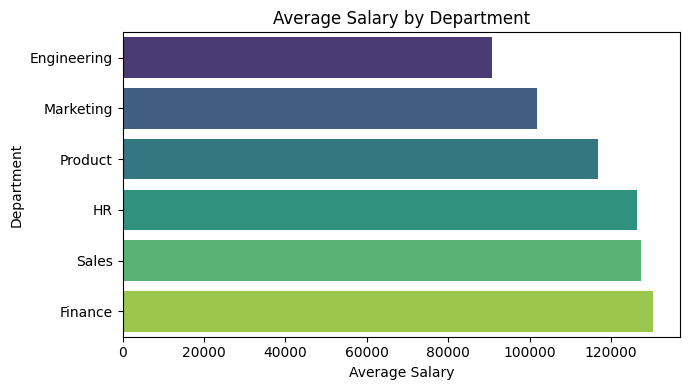

In [12]:
avg_salary_dept = df.groupby("Department")["Salary"].mean().sort_values()

plt.figure(figsize=(7, 4))
sns.barplot(x=avg_salary_dept.values, y=avg_salary_dept.index, palette="viridis")
plt.title("Average Salary by Department")
plt.xlabel("Average Salary")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

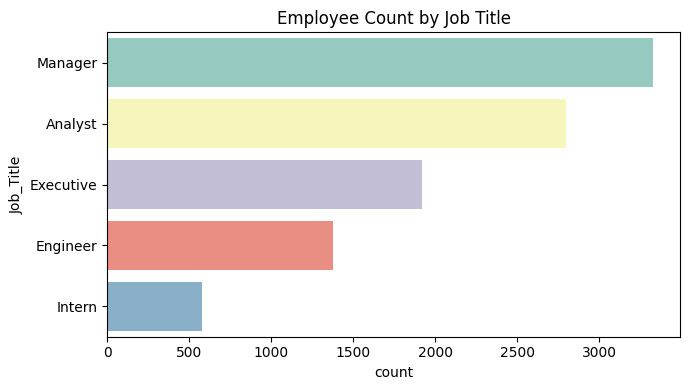

In [13]:
plt.figure(figsize=(7, 4))
sns.countplot(y="Job_Title", data=df, order=df["Job_Title"].value_counts().index, palette="Set3")
plt.title("Employee Count by Job Title")
plt.tight_layout()
plt.show()


Analysts and Managers dominate the workforce (2,000-2,500 employees each), while Executives and Engineers show moderate representation (1,000 and 500), and Interns remain the smallest group (250), indicating a top-heavy organizational structure with strong operational/mid-level presence



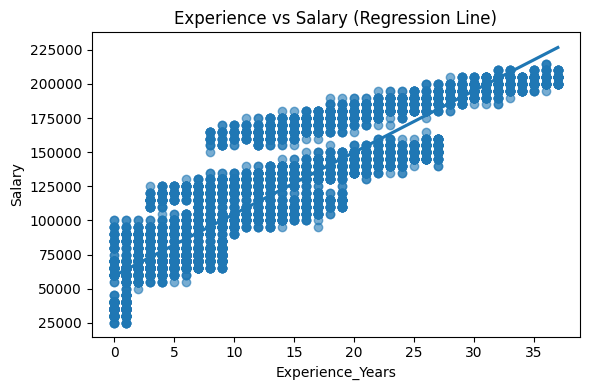

In [14]:
plt.figure(figsize=(6, 4))
sns.regplot(x="Experience_Years", y="Salary", data=df, scatter_kws={"alpha":0.6})
plt.title("Experience vs Salary (Regression Line)")
plt.tight_layout()
plt.show()


Salary shows a strong linear relationship with experience, increasing by approximately $5,000 per year across roles, though with significant individual variability around the trend line.

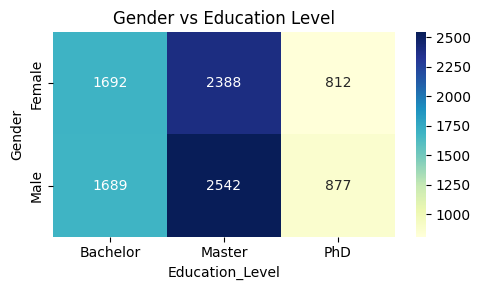

In [15]:
crosstab = pd.crosstab(df["Gender"], df["Education_Level"])

plt.figure(figsize=(5, 3))
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Gender vs Education Level")
plt.tight_layout()
plt.show()

Females outnumber males across all education levels—most notably in Master's (2,542 vs 1,689) and Bachelor's (2,388 vs 1,692)—while PhD representation shows the smallest gender gap (877 females vs 812 males), indicating higher female educational attainment in this workforce.

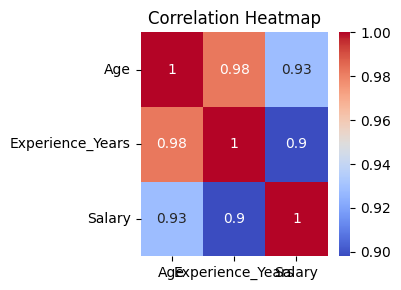

In [16]:
plt.figure(figsize=(4, 3))
sns.heatmap(df.select_dtypes(include=["int64", "float64"]).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

We see a high colinearity score between  Age and Experience_Years, dropping one of them will be better for model perforemance.

In [17]:
df = df.drop(columns=["Age"])


## Data Preprocessing

In [18]:
categorical_cols = ['Gender', 'Department', 'Job_Title', 'Education_Level', 'Location']
numeric_cols = ['Experience_Years']

In [19]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])


In [20]:
X = df.drop(columns=['Salary'])
y = df['Salary']

Transform X

In [21]:
X = preprocessor.fit_transform(X)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Selection

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=2)
}


In [24]:
results = []

for name, model in models.items():

    

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R^2 Score": r2
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by="RMSE")

,Model,MAE,RMSE,R^2 Score
0,Linear Regression,3336.214246,4166.620221,0.991763
2,Random Forest,3909.753504,4917.318163,0.988528
3,KNN Regressor,4257.500000,5454.356057,0.985885
1,Decision Tree,4208.893704,5478.738583,0.985758


## Model Training And Evaluation

In [25]:
model = LinearRegression()


In [26]:
model.fit(X_train, y_train)

LinearRegression()

In [27]:
y_pred = model.predict(X_test)

In [28]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


In [29]:
print("Linear Regression Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Linear Regression Evaluation:
MAE: 3336.21
RMSE: 4166.62
R² Score: 0.9918


We got R2 0.99 score, that is a pretty good score.

## Save the model

In [30]:
import joblib
joblib.dump(model, "linear_regression_employer_model.pkl")


['linear_regression_employer_model.pkl']